In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
from torch import nn, optim

from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR

In [3]:
import sys
sys.path.append("./../../")

from config_reader import ConfigReader
from modules.dvae.model import DVAE
from modules.transformer_gen.ar_cond_1stream.generator import LatentGenerator as LatentGenerator1s
from modules.transformer_gen.ar_cond_2stream.generator import LatentGenerator as LatentGenerator2s
from datasets.mnist_loader import MNISTData
from notebooks.utils import show
from modules.common_utils import latent_to_img
from utilities.md_mnist_utils import LabelsInfo

In [4]:
config_dir_path = '/u/82/sukhoba1/unix/Desktop/TA-VQVAE/configs/finished/'
config_path_1s2s = config_dir_path + 'Tr1s2s_mnistmd_v256_ds2_nb12_remote.yaml'
config_path_2s2s = config_dir_path + 'Tr2s2s_mnistmd_v256_ds2_nb12_cnb6_remote.yaml'

CONFIG_1s2s = ConfigReader(config_path=config_path_1s2s)
CONFIG_2s2s = ConfigReader(config_path=config_path_2s2s)

In [5]:
dvae = DVAE(
    in_channels=CONFIG_1s2s.in_channels,
    vocab_size=CONFIG_1s2s.vocab_size,
    num_x2downsamples=CONFIG_1s2s.num_x2downsamples,
    num_resids_downsample=CONFIG_1s2s.num_resids_downsample,
    num_resids_bottleneck=CONFIG_1s2s.num_resids_bottleneck,
    hidden_dim=CONFIG_1s2s.hidden_dim,
    device=CONFIG_1s2s.DEVICE)

dvae.eval()
dvae.load_model(
    root_path=CONFIG_1s2s.vae_model_path,
    model_name=CONFIG_1s2s.vae_model_name)

G1s = LatentGenerator1s(
    hidden_width=CONFIG_1s2s.hidden_width,
    hidden_height=CONFIG_1s2s.hidden_height,
    embedding_dim=CONFIG_1s2s.vocab_size,
    num_blocks=CONFIG_1s2s.num_blocks,
    cond_seq_size=CONFIG_1s2s.cond_seq_size,
    cond_vocab_size=CONFIG_1s2s.cond_vocab_size,
    hidden_dim=CONFIG_1s2s.hidden_dim,
    n_attn_heads=CONFIG_1s2s.n_attn_heads,
    dropout_prob=CONFIG_1s2s.dropout_prob,
    device=CONFIG_1s2s.DEVICE)

G1s.eval()
G1s.load_model(
    root_path=CONFIG_1s2s.save_model_path,
    model_name=CONFIG_1s2s.save_model_name)

G2s = LatentGenerator2s(
    hidden_width=CONFIG_2s2s.hidden_width,
    hidden_height=CONFIG_2s2s.hidden_height,
    embedding_dim=CONFIG_2s2s.vocab_size,
    num_blocks=CONFIG_2s2s.num_blocks,
    cond_num_blocks=CONFIG_2s2s.cond_num_blocks,
    cond_seq_size=CONFIG_2s2s.cond_seq_size,
    cond_vocab_size=CONFIG_2s2s.cond_vocab_size,
    hidden_dim=CONFIG_2s2s.hidden_dim,
    n_attn_heads=CONFIG_2s2s.n_attn_heads,
    dropout_prob=CONFIG_2s2s.dropout_prob,
    device=CONFIG_2s2s.DEVICE)

G2s.eval()
G2s.load_model(
    root_path=CONFIG_2s2s.save_model_path,
    model_name=CONFIG_2s2s.save_model_name)


pass

# Generation from the description

In [30]:
description = [
    ['8', '30', 'r', 'up',     '3', '20', 'g', 'up',     '2', '20', 'w', 'middle'],
    ['5', '30', 'g', 'middle', '2', '30', 'w', 'down',   '4', '20', 'w', 'down'],
    ['5', '40', 'r', 'down',   '3', '30', 'w', 'middle', '0', '40', 'b', 'down'],
    ['8', '20', 'g', 'down',   '7', '40', 'w', 'middle', '2', '20', 'w', 'middle'],
    ['9', '30', 'r', 'middle', '2', '30', 'w', 'down',   '2', '40', 'r', 'down'],
    ['5', '30', 'g', 'up',     '2', '40', 'g', 'up',     '6', '40', 'w', 'down'],
    ['8', '30', 'g', 'middle', '4', '30', 'r', 'middle', '0', '40', 'r', 'up'],
    ['6', '40', 'b', 'down',   '4', '20', 'r', 'middle', '1', '20', 'g', 'down']
]

json_path = '/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/multi_descriptive_MNIST/description/labels_info.json'
li = LabelsInfo(json_path)

description_ids = li.encode_values(description)

description_tensor = torch.LongTensor(description_ids).T.to(CONFIG_1s2s.DEVICE)

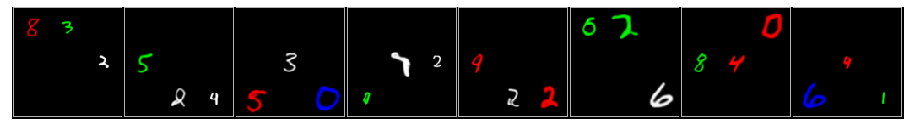

In [31]:
with torch.no_grad():
    g1_lat = G1s.sample(description_tensor)

g1_img = latent_to_img(g1_lat, dvae, CONFIG_1s2s.hidden_height, CONFIG_1s2s.hidden_width)
show(g1_img, figsize=(16,16), plot_grid=True)

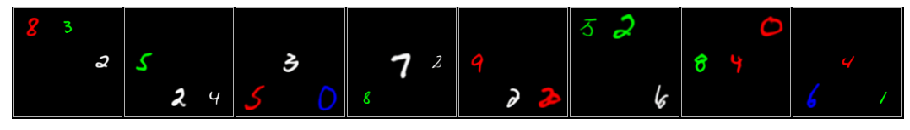

In [32]:
with torch.no_grad():
    g2_lat = G2s.sample(description_tensor)

g2_img = latent_to_img(g2_lat, dvae, CONFIG_2s2s.hidden_height, CONFIG_2s2s.hidden_width)
show(g2_img, figsize=(16,16), plot_grid=True)

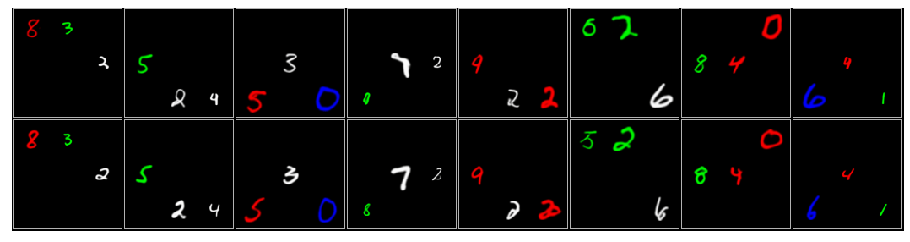

In [33]:
g = torch.cat([g1_img, g2_img], dim=0)

show(g, figsize=(16,16), plot_grid=True)

In [38]:
img_1 = g1_img.detach().cpu().numpy()
img_2 = g2_img.detach().cpu().numpy()

In [41]:
img_1.shape

(8, 3, 128, 128)

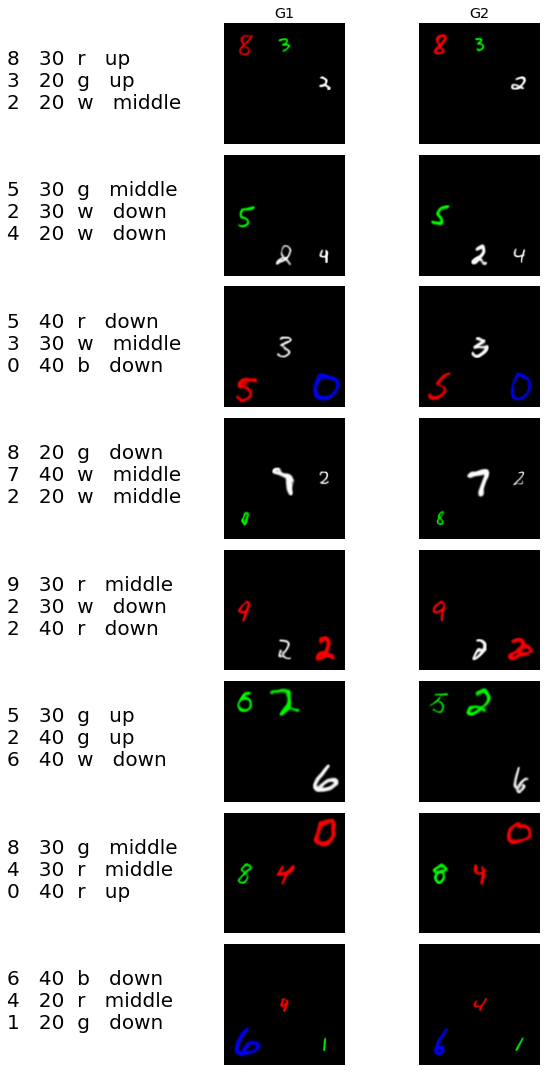

In [84]:
def description_lines(d):
    return '{:<3} {:<3} {:<3} {:<3}\n{:<3} {:<3} {:<3} {:<3}\n{:<3} {:<3} {:<3} {:<3}'.format(*d)


fig = plt.figure(figsize=(8, 15))
rows = 8
columns = 3

for r in range(rows):
    for c in range(columns):
        num = columns * r + c + 1
        
        if c==0:
            fig.add_subplot(rows, columns, num)
            plt.text(0, 0.3, description_lines(description[r]), size=20)
            plt.axis('off')
        elif c==1:
            fig.add_subplot(rows, columns, num)
            plt.imshow(np.moveaxis(img_1[r], 0, -1))
            plt.axis('off')
        elif c==2:
            fig.add_subplot(rows, columns, num)
            plt.imshow(np.moveaxis(img_2[r], 0, -1))
            plt.axis('off')
        
        if r==0:
            if c==1:
                plt.title('G1')
            elif c==2:
                plt.title('G2')

plt.tight_layout()
plt.show()

# Comparison by loss

In [9]:
data_source = MNISTData(
    img_type=CONFIG_1s2s.dataset_type,
    root_path=CONFIG_1s2s.root_path,
    batch_size=CONFIG_1s2s.BATCH_SIZE)

train_loader = data_source.get_train_loader(batch_size=10)

In [10]:
loss_1s = 0
loss_2s = 0
n_obs = 0
loss_values_1s = []
loss_values_2s = []

for i in tqdm(range(100)):
    
    img, tokens = next(iter(train_loader))

    img = img.to(CONFIG_1s2s.DEVICE)
    tokens = tokens.permute(1, 0).to(CONFIG_1s2s.DEVICE)

    with torch.no_grad():
        latent = dvae.ng_q_encode(img)

        b, emb, h, w = latent.size()
        x = latent.view(b, emb, -1).permute(2, 0, 1)

        start_vector = torch.zeros(1, b, emb, device=x.device)
        x_inp = torch.cat([start_vector, x[:-1,:,:]], dim=0)

        x_out_1s = G1s.forward(x_inp, tokens)
        x_out_2s = G2s.forward(x_inp, tokens)

        seq_lables_true = x.argmax(dim=2).view(-1)
        seq_labels_pred_1s = x_out_1s.view(-1, emb)
        seq_labels_pred_2s = x_out_2s.view(-1, emb)

        loss_1s += F.cross_entropy(seq_labels_pred_1s, seq_lables_true, reduction='sum')
        loss_2s += F.cross_entropy(seq_labels_pred_2s, seq_lables_true, reduction='sum')
        n_obs += 10 * 1024
        
        loss_values_1s += F.cross_entropy(seq_labels_pred_1s, seq_lables_true, reduction='none').tolist()
        loss_values_2s += F.cross_entropy(seq_labels_pred_2s, seq_lables_true, reduction='none').tolist()

print('N observations:', n_obs)
print('Loss 1s:', loss_1s / n_obs)
print('Loss 2s:', loss_2s / n_obs)

  0%|          | 0/100 [00:00<?, ?it/s]

N observations: 1024000
Loss 1s: tensor(0.3100, device='cuda:0')
Loss 2s: tensor(0.3006, device='cuda:0')


In [11]:
plt.style.use('ggplot')

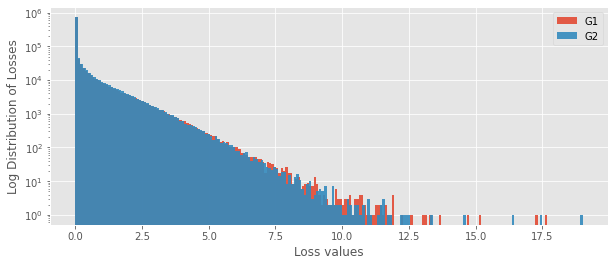

In [34]:
plt.figure(figsize=(10,4))
plt.hist(loss_values_1s, bins=200, log=True, histtype='bar', alpha=0.9, label='G1')
plt.hist(loss_values_2s, bins=200, log=True, histtype='bar', alpha=0.9, label='G2')
plt.xlabel('Loss values')
plt.ylabel('Log Distribution of Losses')
plt.legend()
plt.show()